In [142]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import matplotlib

In [143]:
INPUT_PATH = '../data/postprocessing/231212_compare_electrolyzers/'

In [144]:
file_names = [INPUT_PATH + i + 'x_gas_wo_storage_output_time_series.csv' for i in ['1', '3', '4', '5', '6', '7', '8', '9', '10']]
file_data = {}

for file in file_names:
    key_name = file.replace('../data/postprocessing/231212_compare_electrolyzers/', '')
    key_name = key_name.replace('_output_time_series.csv', '')
    file_data[key_name] = pd.read_csv(file, index_col=0)

In [145]:
def calc_costs(key):
    data = file_data[key]
    gas_factor = float(re.sub('x.*$', '', key))
    costs = (data['chp.gas'] * data['gas_price'] +
             data['electrical_grid.overall_power'] * data['power_price'] +
             data['hydrogen_grid.overall_hydrogen'] * data['gas_price'] * gas_factor
            ) 

    return costs

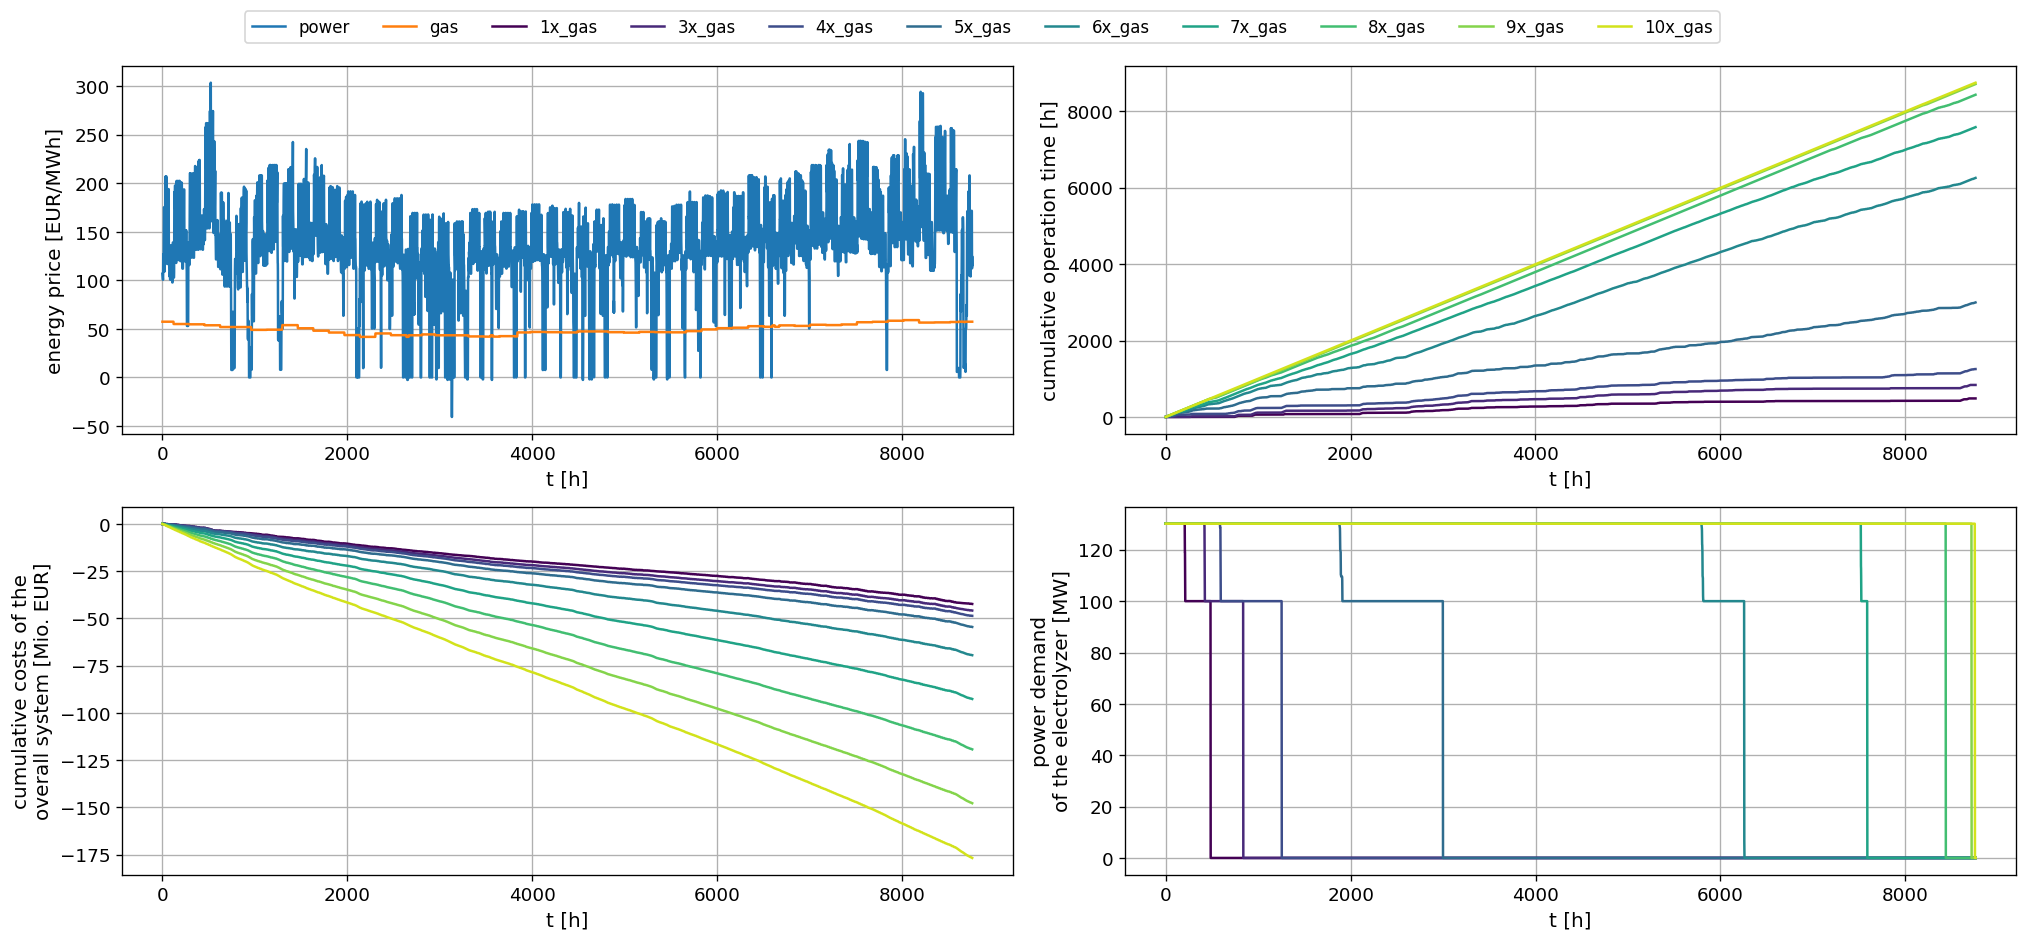

In [179]:
FONTSIZE = 12
LABELSIZE = 11

plt.rc('xtick', labelsize=LABELSIZE)
plt.rc('ytick', labelsize=LABELSIZE)

color_map = matplotlib.colormaps['viridis']   # choose colormap

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(17, 7.5), dpi=120)    # figsize in inches as default wide-screen resolution

aux_key = next(iter(file_data.keys()))   # get any key from the dict to access price data

axs[0, 0].plot(file_data[aux_key]['power_price'], label=('power'))
axs[0, 0].plot(file_data[aux_key]['gas_price'], label=('gas'))
axs[0, 0].set_xlabel('t [h]', fontsize=FONTSIZE)
axs[0, 0].set_ylabel('energy price [EUR/MWh]', fontsize=FONTSIZE)

for pos, key in enumerate(file_data.keys()):
    plot_color = color_map(pos / (len(file_data.keys()) - 0.4))    # declare gradient from the colormap that is to use as color for the plot
    axs[0, 1].plot(file_data[key]['electrolyzer.bin'].cumsum(), label=key.replace('_wo_storage', ''), color=plot_color)
    axs[0, 1].set_xlabel('t [h]', fontsize=FONTSIZE)
    axs[0, 1].set_ylabel('cumulative operation time [h]', fontsize=FONTSIZE)

    axs[1, 1].plot(file_data[key]['electrolyzer.power'].sort_values(ascending=False, ignore_index=True), color=plot_color)
    axs[1, 1].set_xlabel('t [h]', fontsize=FONTSIZE)
    axs[1, 1].set_ylabel('power demand\nof the electrolyzer [MW]', fontsize=FONTSIZE)

    axs[1, 0].plot(calc_costs(key).cumsum() / 1000000, color=plot_color)
    axs[1, 0].set_xlabel('t [h]', fontsize=FONTSIZE)
    axs[1, 0].set_ylabel('cumulative costs of the\noverall system [Mio. EUR]', fontsize=FONTSIZE)

axs[0, 0].grid()
axs[0, 1].grid()
axs[1, 0].grid()
axs[1, 1].grid()


handle_labels = [ax.get_legend_handles_labels() for ax in fig.axes]   # gets the handles and labels as tuple for every subplot
handles, labels = [sum(lists, []) for lists in zip(*handle_labels)]   # concatenates the handles and labels into two individual lists


fig.legend(handles, labels, ncols=11, bbox_to_anchor=(0.85, 1.05))
fig.tight_layout()